# ST 590-651 Project 2 Part 2: Northwind Data Analysis

*Performed by Group G: Raiden Han, Jingjing Li, Nataliya Peshekhodko*

*06/27/2022*

## Introduction and Module Preparation

This section will analyze the [Northwind sample database](https://github.com/jpwhite3/northwind-SQLite3) provided with Microsoft Access 2000 and from Github, using `SQLite3` and other Python modules.

![Northwind](images/Northwind_ERD.png)

To begin with, we will import the necessary modules and build a connection to the database.

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

# Build a connection to the database
con = sqlite3.connect(r"data/northwind.sqlite")

## Data Integration and Analysis

Before performing any data analysis, we want to check the schema of the database to ensure that the tables contained in our database are consistent with the entity-relationship diagram above and to determine the integrity of the data.

In [2]:
pd.read_sql_query(
    """
    SELECT *
    FROM sqlite_schema
    WHERE type = 'table';
    """,
    con,
)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
3,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
4,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
7,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
8,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
9,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...


Next, we will analyze the above tables in combination.

### Employees' Information

In [3]:
employee_info = pd.read_sql_query(
    """
    SELECT EmployeeID, FirstName, LastName, 
    Title, City, Country, ReportsTo 
    FROM Employees
    """,
    con,
)
employee_info

,EmployeeID,FirstName,LastName,Title,City,Country,ReportsTo
0,1,Nancy,Davolio,Sales Representative,Seattle,USA,2.0
1,2,Andrew,Fuller,"Vice President, Sales",Tacoma,USA,NaN
2,3,Janet,Leverling,Sales Representative,Kirkland,USA,2.0
3,4,Margaret,Peacock,Sales Representative,Redmond,USA,2.0
4,5,Steven,Buchanan,Sales Manager,London,UK,2.0
5,6,Michael,Suyama,Sales Representative,London,UK,5.0
6,7,Robert,King,Sales Representative,London,UK,5.0
7,8,Laura,Callahan,Inside Sales Coordinator,Seattle,USA,2.0
8,9,Anne,Dodsworth,Sales Representative,London,UK,5.0


In [4]:
employee_territory = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName,
    t.TerritoryDescription as Territory, r.RegionDescription as Region
    FROM Employees e
    INNER JOIN EmployeeTerritories et
    ON e.EmployeeID = et.EmployeeID
    INNER JOIN Territories t
    ON et.TerritoryID = t.TerritoryID
    INNER JOIN Regions r
    ON t.RegionID = r.RegionID
    """,
    con,
)
employee_territory["Territory"] = employee_territory["Territory"].str.strip()
employee_territory["Region"] = employee_territory["Region"].str.strip()
employee_territory

,EmployeeID,FirstName,LastName,Territory,Region
0,1,Nancy,Davolio,Wilton,Eastern
1,1,Nancy,Davolio,Neward,Eastern
2,2,Andrew,Fuller,Westboro,Eastern
3,2,Andrew,Fuller,Bedford,Eastern
4,2,Andrew,Fuller,Georgetow,Eastern
5,2,Andrew,Fuller,Boston,Eastern
6,2,Andrew,Fuller,Cambridge,Eastern
7,2,Andrew,Fuller,Braintree,Eastern
8,2,Andrew,Fuller,Louisville,Eastern
9,3,Janet,Leverling,Atlanta,Southern


### Employees & Orders

First, we will merge the employee form with the order form to get an overview of each employee's order information. In particular, we will keep the order date and freight and calculate the shipping time and the number of early arrival days.

In [5]:
employee_order = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName, 
    o.OrderID, o.orderDate, o.Freight, 
    JULIANDAY(o.ShippedDate) - JULIANDAY(o.OrderDate) AS ShippingDay, 
    JULIANDAY(o.RequiredDate) - JULIANDAY(o.ShippedDate) AS EarlyDay
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID;
    """,
    con,
)
employee_order.head()

,EmployeeID,FirstName,LastName,OrderID,OrderDate,Freight,ShippingDay,EarlyDay
0,5,Steven,Buchanan,10248,1996-07-04 00:00:00.000,32.38,12.0,16.0
1,6,Michael,Suyama,10249,1996-07-05 00:00:00.000,11.61,5.0,37.0
2,4,Margaret,Peacock,10250,1996-07-08 00:00:00.000,65.83,4.0,24.0
3,3,Janet,Leverling,10251,1996-07-08 00:00:00.000,41.34,7.0,21.0
4,4,Margaret,Peacock,10252,1996-07-09 00:00:00.000,51.30,2.0,26.0


We will aggregate the total number of orders for each employee in our database and sort them in descending order.

In [6]:
tope = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName, COUNT(*) AS OrderCount
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    GROUP BY e.EmployeeID
    ORDER BY OrderCount DESC;
    """,
    con,
)
tope

,EmployeeID,FirstName,LastName,OrderCount
0,4,Margaret,Peacock,156
1,3,Janet,Leverling,127
2,1,Nancy,Davolio,123
3,8,Laura,Callahan,104
4,2,Andrew,Fuller,96
5,7,Robert,King,72
6,6,Michael,Suyama,67
7,9,Anne,Dodsworth,43
8,5,Steven,Buchanan,42


The table above shows a large variation in the number of orders completed by individual employees in the company. Margaret Peacock has the highest number of orders at 156, while Steven Buchanan has the lowest number of orders at 42.

To better understand how the number of orders per employee changes over time, we will summarize the number of orders per employee on a six-month cycle and draw a line graph.

In [7]:
# Convert the OrderDate column to the TimeStamp data type
employee_order["OrderDate"] = pd.to_datetime(employee_order["OrderDate"])
# Count the half-year order numbers grouped by employees
order_count_time = (
    employee_order.groupby(["EmployeeID", "FirstName", "LastName"])
    .resample("2QS", on="OrderDate")
    .count()
    .iloc[:, 0]
    .rename("OrderCount")
    .reset_index()
)
order_count_time.head()

,EmployeeID,FirstName,LastName,OrderDate,OrderCount
0,1,Nancy,Davolio,1996-07-01,26
1,1,Nancy,Davolio,1997-01-01,20
2,1,Nancy,Davolio,1997-07-01,35
3,1,Nancy,Davolio,1998-01-01,42
4,2,Andrew,Fuller,1996-07-01,16


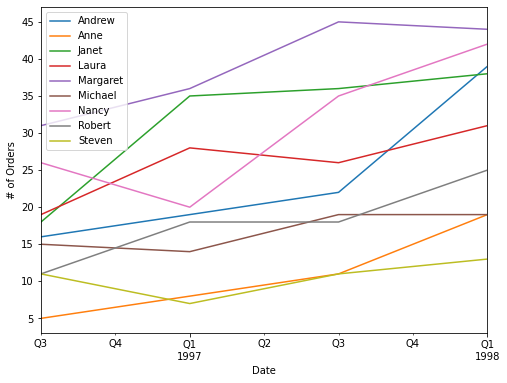

In [8]:
# Set the date as index
order_count_time.set_index("OrderDate", inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
order_count_time.groupby("FirstName")["OrderCount"].plot(ax=ax, legend=True)
ax.set_xlabel("Date")
ax.set_ylabel("# of Orders")
plt.show()

The line graph above reveals an important piece of information: the order data for all employees starts at approximately the same time. As time passes, the number of orders for each employee shows an upward trend, but the level does not change significantly. Also, the graph shows that Margaret has the most orders and Steven has the least orders, which is consistent with the previously described results.

In [9]:
employee_order.groupby("FirstName")["Freight"].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,96.0,90.587604,142.054368,0.17,11.4225,45.560,92.7575,810.05
Anne,43.0,77.354884,128.135494,0.48,12.2550,30.850,93.3000,754.26
Janet,127.0,85.706614,146.117021,0.14,12.3700,43.900,90.4900,1007.64
Laura,104.0,71.998846,82.756930,0.33,12.5500,38.485,104.6925,398.36
Margaret,156.0,72.731667,103.157357,0.02,14.7000,42.965,81.8875,719.78
Michael,67.0,56.424925,74.193019,0.12,6.7000,27.330,71.0350,367.63
Nancy,123.0,71.842602,82.424136,0.21,21.6950,44.150,95.0300,544.08
Robert,72.0,92.575556,140.633406,0.40,16.4175,42.005,90.1700,830.75
Steven,42.0,93.302619,153.469722,0.59,15.7500,41.745,122.7825,890.78


In [10]:
employee_order.groupby("FirstName")["ShippingDay"].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,93.0,8.053763,6.182664,1.0,4.00,7.0,10.00,32.0
Anne,42.0,10.857143,8.623766,1.0,6.25,7.0,10.75,34.0
Janet,127.0,8.425197,6.788786,1.0,5.00,7.0,9.00,35.0
Laura,100.0,8.680000,7.821080,1.0,4.00,6.0,9.25,37.0
Margaret,151.0,8.821192,6.978143,1.0,5.00,7.0,10.00,35.0
Michael,65.0,9.092308,7.242934,1.0,5.00,7.0,10.00,32.0
Nancy,120.0,7.758333,5.562473,1.0,4.00,6.5,9.00,34.0
Robert,69.0,8.376812,7.487443,1.0,4.00,7.0,9.00,37.0
Steven,42.0,7.023810,4.279777,1.0,4.25,6.5,9.00,25.0


In [11]:
employee_order.groupby("FirstName")["EarlyDay"].describe()

,count,mean,std,min,25%,50%,75%,max
FirstName,,,,,,,,
Andrew,93.0,19.344086,8.778054,-16.0,18.00,21.0,24.0,41.0
Anne,42.0,16.809524,11.828527,-17.0,8.75,21.0,23.0,37.0
Janet,127.0,19.133858,8.025121,-7.0,18.00,21.0,23.0,39.0
Laura,100.0,20.440000,9.995272,-9.0,18.00,22.0,25.0,39.0
Margaret,151.0,18.251656,8.662731,-18.0,16.50,21.0,23.5,34.0
Michael,65.0,19.338462,9.346251,-18.0,18.00,21.0,23.0,39.0
Nancy,120.0,19.775000,7.738871,-11.0,18.00,22.0,24.0,36.0
Robert,69.0,20.434783,9.540129,-23.0,19.00,22.0,25.0,36.0
Steven,42.0,20.976190,7.875520,-1.0,19.00,22.0,24.0,39.0


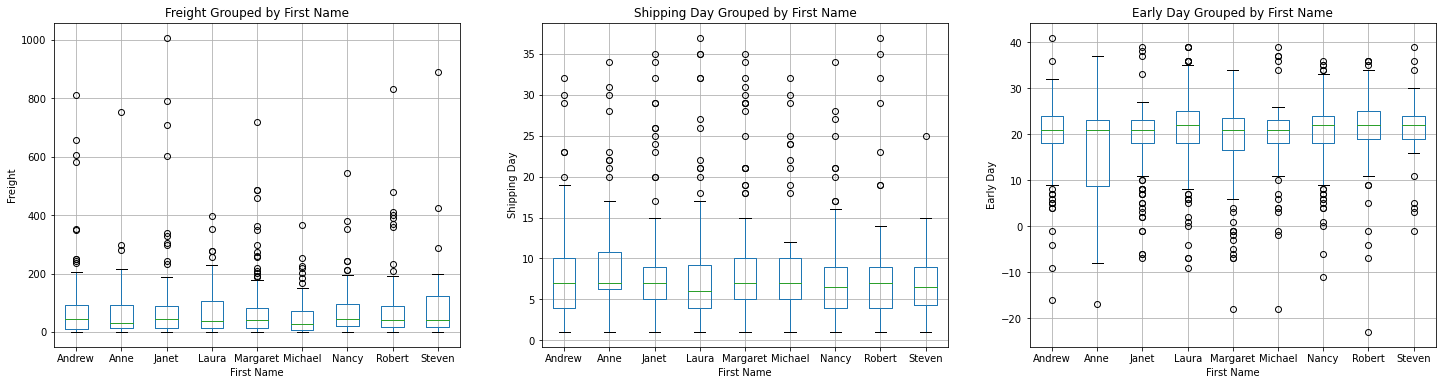

In [12]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=3, figsize=(24, 6))
# Create boxplots
employee_order.boxplot(column="Freight", by="FirstName", ax=ax[0])
employee_order.boxplot(column="ShippingDay", by="FirstName", ax=ax[1])
employee_order.boxplot(column="EarlyDay", by="FirstName", ax=ax[2])
# Add labels
ax[0].set_title("Freight Grouped by First Name")
ax[0].set_xlabel("First Name")
ax[0].set_ylabel("Freight")
ax[1].set_title("Shipping Day Grouped by First Name")
ax[1].set_xlabel("First Name")
ax[1].set_ylabel("Shipping Day")
ax[2].set_title("Early Day Grouped by First Name")
ax[2].set_xlabel("First Name")
ax[2].set_ylabel("Early Day")
plt.suptitle("")
# Show the image
plt.show()

### Employees & Product Details

In [13]:
employee_category = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName, c.CategoryName, 
    s.CompanyName AS Supplier, od.OrderID, od.ProductID, 
    od.UnitPrice, od.Quantity, od.Discount
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    INNER JOIN "Order Details" od
    ON o.OrderID = od.OrderID
    INNER JOIN Products p 
    ON od.ProductID = p.ProductID
    INNER JOIN Categories c
    ON p.CategoryID = c.CategoryID
    INNER JOIN Suppliers s
    ON p.SupplierID = s.SupplierID;
    """,
    con,
)
employee_category.head()

,EmployeeID,FirstName,LastName,CategoryName,Supplier,OrderID,ProductID,UnitPrice,Quantity,Discount
0,5,Steven,Buchanan,Dairy Products,Cooperativa de Quesos 'Las Cabras',10248,11,14.0,12,0.0
1,5,Steven,Buchanan,Grains/Cereals,Leka Trading,10248,42,9.8,10,0.0
2,5,Steven,Buchanan,Dairy Products,Formaggi Fortini s.r.l.,10248,72,34.8,5,0.0
3,6,Michael,Suyama,Produce,Mayumi's,10249,14,18.6,9,0.0
4,6,Michael,Suyama,Produce,"G'day, Mate",10249,51,42.4,40,0.0


In [14]:
employee_category["Value"] = (
    employee_category["UnitPrice"]
    * employee_category["Quantity"]
    * (1 - employee_category["Discount"])
)
employee_category.head()

,EmployeeID,FirstName,LastName,CategoryName,Supplier,OrderID,ProductID,UnitPrice,Quantity,Discount,Value
0,5,Steven,Buchanan,Dairy Products,Cooperativa de Quesos 'Las Cabras',10248,11,14.0,12,0.0,168.0
1,5,Steven,Buchanan,Grains/Cereals,Leka Trading,10248,42,9.8,10,0.0,98.0
2,5,Steven,Buchanan,Dairy Products,Formaggi Fortini s.r.l.,10248,72,34.8,5,0.0,174.0
3,6,Michael,Suyama,Produce,Mayumi's,10249,14,18.6,9,0.0,167.4
4,6,Michael,Suyama,Produce,"G'day, Mate",10249,51,42.4,40,0.0,1696.0


In [15]:
employee_order_value = (
    employee_category.groupby(["FirstName", "OrderID"])[
        ["Value"]].sum().reset_index()
)
employee_order_value.head()

,FirstName,OrderID,Value
0,Andrew,10265,1176.0
1,Andrew,10277,1200.8
2,Andrew,10280,613.2
3,Andrew,10295,121.6
4,Andrew,10300,608.0


In [16]:
employee_total_value = (
    employee_order_value.groupby("FirstName")[["Value"]].sum().reset_index()
)
employee_total_value.head()

,FirstName,Value
0,Andrew,166537.7550
1,Anne,77308.0665
2,Janet,202812.8430
3,Laura,126862.2775
4,Margaret,232890.8460


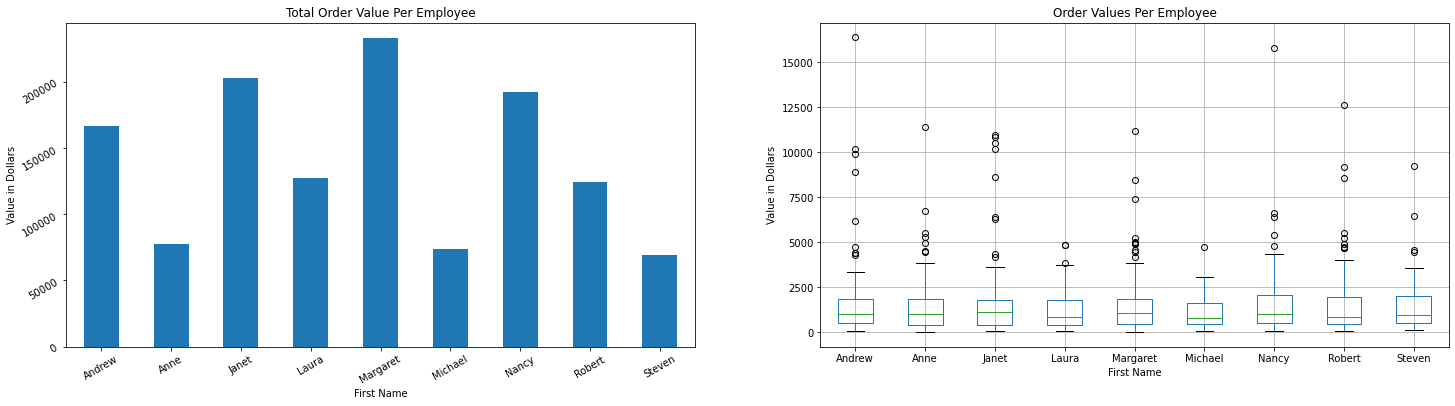

In [17]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create boxplots
employee_total_value.plot(x="FirstName", y="Value",
                          kind="bar", ax=ax[0], legend=False)
employee_order_value.boxplot(column="Value", by="FirstName", ax=ax[1])
# Add labels
ax[0].set_title("Total Order Value Per Employee")
ax[0].set_xlabel("First Name")
ax[0].set_ylabel("Value in Dollars")
ax[0].tick_params(labelrotation=30)
ax[1].set_title("Order Values Per Employee")
ax[1].set_xlabel("First Name")
ax[1].set_ylabel("Value in Dollars")
plt.suptitle("")
# Show the image
plt.show()

In [18]:
employee_cat_quantity_value = employee_category.groupby(
    ["FirstName", "CategoryName"]
).agg({"Quantity": sum, "Value": sum})
employee_cat_quantity_value.reset_index(inplace=True)
employee_cat_quantity_value.head()

,FirstName,CategoryName,Quantity,Value
0,Andrew,Beverages,1069,40248.250
1,Andrew,Condiments,709,14850.670
2,Andrew,Confections,863,21455.685
3,Andrew,Dairy Products,910,23812.550
4,Andrew,Grains/Cereals,645,11172.950


In [19]:
employee_cat_quantity_pivot = pd.pivot_table(
    employee_cat_quantity_value,
    index="FirstName",
    columns="CategoryName",
    values="Quantity",
)
employee_cat_quantity_pivot.head()

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
FirstName,,,,,,,,
Andrew,1069,709,863,910,645,702,297,860
Anne,519,493,365,639,74,135,41,404
Janet,1310,670,1346,1308,887,525,327,1479
Laura,1308,634,989,726,688,419,411,738
Margaret,1572,1252,1535,1455,1000,921,558,1505


In [20]:
employee_cat_value_pivot = pd.pivot_table(
    employee_cat_quantity_value,
    index="FirstName",
    columns="CategoryName",
    values="Value",
)
employee_cat_value_pivot.head()

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
FirstName,,,,,,,,
Andrew,40248.250,14850.6700,21455.6850,23812.550,11172.95,29873.600,9376.4800,15747.5700
Anne,19642.555,10125.5450,8053.1640,21101.125,1245.30,8676.660,314.8125,8148.9050
Janet,44757.405,13381.6375,33622.3955,32320.835,21235.01,20502.615,11960.8500,25032.0950
Laura,17897.850,14637.6600,21699.9125,21101.470,11072.05,16395.275,12016.5175,12041.5425
Margaret,50308.210,23314.8725,27768.7250,33549.800,22579.61,30867.136,17186.5625,27315.9300


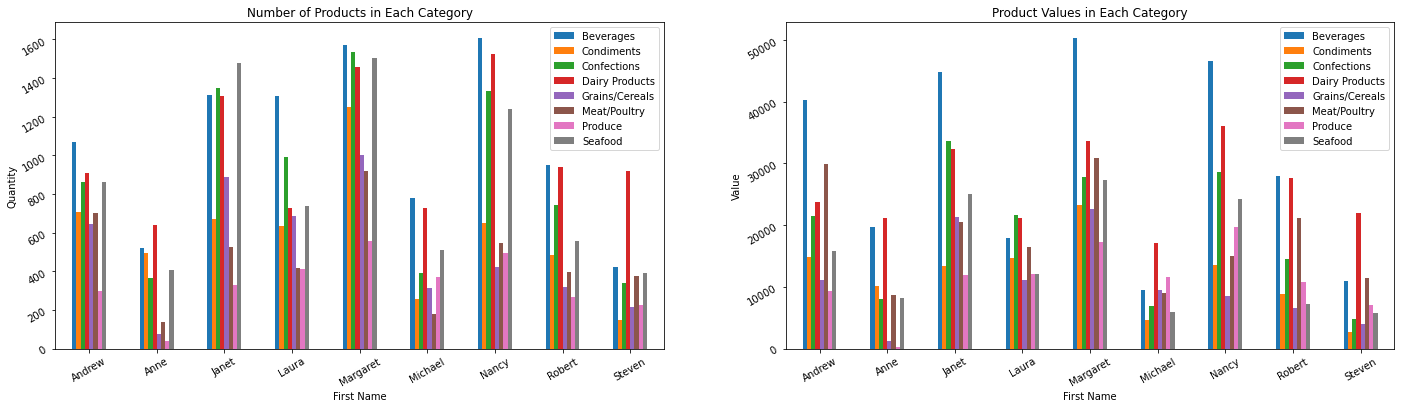

In [21]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create barplots
employee_cat_quantity_pivot.plot(kind="bar", ax=ax[0])
employee_cat_value_pivot.plot(kind="bar", ax=ax[1])
# Add labels
ax[0].set_title("Number of Products in Each Category")
ax[0].set_xlabel("First Name")
ax[0].set_ylabel("Quantity")
ax[0].tick_params(labelrotation=30)
ax[0].get_legend().set_title("")
ax[1].set_title("Product Values in Each Category")
ax[1].set_xlabel("First Name")
ax[1].set_ylabel("Value")
ax[1].tick_params(labelrotation=30)
ax[1].get_legend().set_title("")
# Show the image
plt.show()

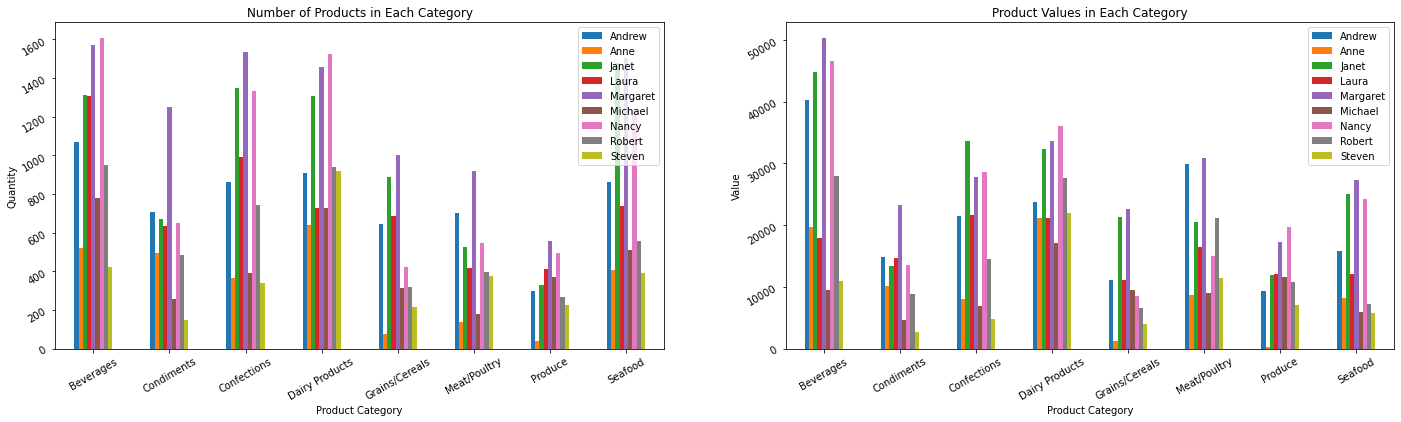

In [22]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create barplots
employee_cat_quantity_pivot.T.plot(kind="bar", ax=ax[0])
employee_cat_value_pivot.T.plot(kind="bar", ax=ax[1])
# Add labels
ax[0].set_title("Number of Products in Each Category")
ax[0].set_xlabel("Product Category")
ax[0].set_ylabel("Quantity")
ax[0].tick_params(labelrotation=30)
ax[0].get_legend().set_title("")
ax[1].set_title("Product Values in Each Category")
ax[1].set_xlabel("Product Category")
ax[1].set_ylabel("Value")
ax[1].tick_params(labelrotation=30)
ax[1].get_legend().set_title("")
# Show the image
plt.show()

In [23]:
employee_sup_quantity_pivot = pd.pivot_table(
    employee_category,
    index="Supplier",
    columns="FirstName",
    values="Quantity",
    aggfunc=sum,
)
employee_sup_quantity_pivot.head()

FirstName,Andrew,Anne,Janet,Laura,Margaret,Michael,Nancy,Robert,Steven
Supplier,,,,,,,,,
Aux joyeux ecclÃ©siastiques,179.0,67.0,212.0,85.0,250.0,151.0,222.0,102.0,148.0
Bigfoot Breweries,266.0,80.0,122.0,281.0,198.0,70.0,154.0,389.0,13.0
Cooperativa de Quesos 'Las Cabras',160.0,75.0,106.0,170.0,102.0,60.0,153.0,172.0,52.0
Escargots Nouveaux,30.0,NaN,145.0,60.0,143.0,NaN,65.0,49.0,42.0
Exotic Liquids,160.0,139.0,296.0,160.0,567.0,226.0,379.0,175.0,111.0


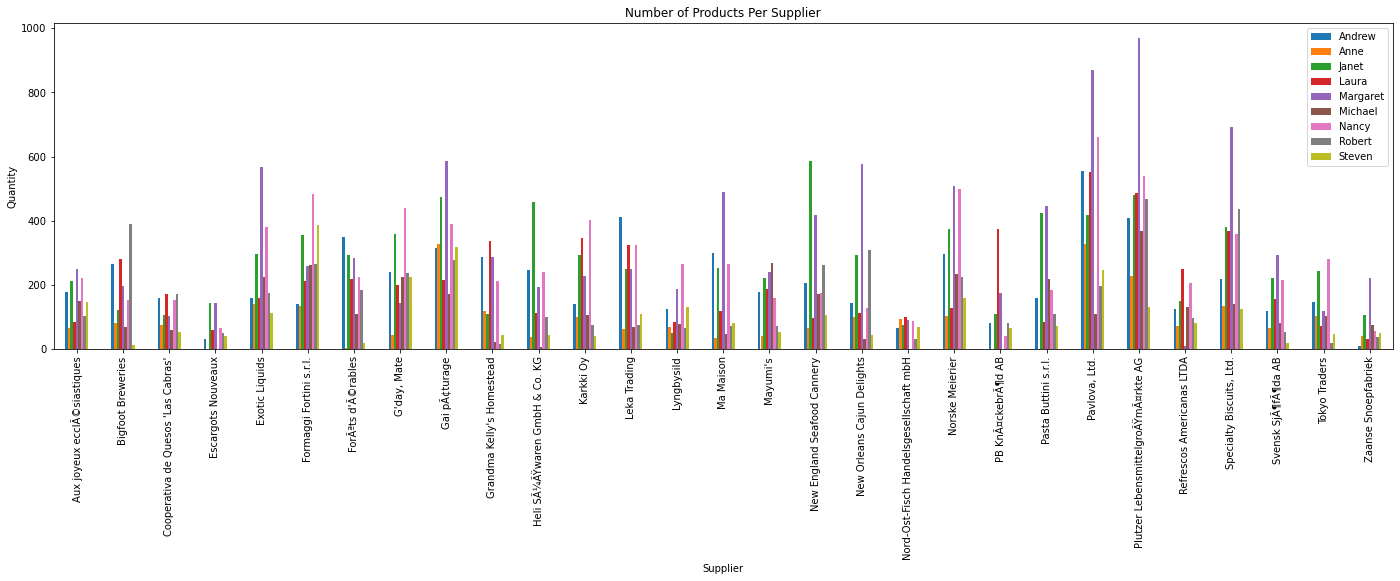

In [24]:
# Plotting
fig, ax = plt.subplots(figsize=(24, 6))
employee_sup_quantity_pivot.plot(kind="bar", ax=ax)
ax.set_title("Number of Products Per Supplier")
ax.set_xlabel("Supplier")
ax.set_ylabel("Quantity")
ax.get_legend().set_title("")
plt.show()

### Employees & Customers

In [25]:
employee_customer_order = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName,
    o.OrderID, c.CustomerID, c.Country
    FROM Employees e
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    INNER JOIN Customers c
    ON o.CustomerID = c.CustomerID;
    """,
    con,
)
employee_customer_order = pd.merge(
    employee_customer_order, employee_order_value, on=["FirstName", "OrderID"]
)
employee_customer_order.head()

,EmployeeID,FirstName,LastName,OrderID,CustomerID,Country,Value
0,5,Steven,Buchanan,10248,VINET,France,440.00
1,6,Michael,Suyama,10249,TOMSP,Germany,1863.40
2,4,Margaret,Peacock,10250,HANAR,Brazil,1552.60
3,3,Janet,Leverling,10251,VICTE,France,654.06
4,4,Margaret,Peacock,10252,SUPRD,Belgium,3597.90


In [26]:
employee_customer = employee_customer_order[
    ["FirstName", "CustomerID"]
].drop_duplicates()
employee_customer = (
    employee_customer.groupby("FirstName")
    .count()
    .reset_index()
    .rename(columns={"CustomerID": "CustomerCount"})
)
employee_customer

,FirstName,CustomerCount
0,Andrew,59
1,Anne,29
2,Janet,63
3,Laura,56
4,Margaret,75
5,Michael,43
6,Nancy,65
7,Robert,45
8,Steven,29


In [27]:
employee_country_order_count = pd.crosstab(
    index=employee_customer_order["FirstName"],
    columns=employee_customer_order["Country"],
)
employee_country_order_count

Country,Argentina,Austria,Belgium,Brazil,Canada,Denmark,Finland,France,Germany,Ireland,...,Mexico,Norway,Poland,Portugal,Spain,Sweden,Switzerland,UK,USA,Venezuela
FirstName,,,,,,,,,,,,,,,,,,,,,
Andrew,1,6,2,9,5,3,6,11,14,3,...,4,1,0,0,2,4,0,5,9,4
Anne,2,3,2,3,1,0,1,3,9,3,...,0,0,0,1,1,2,2,4,3,1
Janet,1,5,1,10,9,1,2,13,19,5,...,6,1,0,2,3,8,3,8,21,8
Laura,3,5,0,9,2,2,4,8,17,1,...,2,0,1,2,2,8,1,6,19,9
Margaret,4,6,6,20,3,3,3,14,25,1,...,4,0,2,3,7,3,4,12,22,8
Michael,1,4,1,8,3,1,1,9,9,3,...,0,0,1,0,0,2,2,5,14,2
Nancy,1,5,1,11,5,4,2,9,19,1,...,6,2,2,2,3,5,2,9,21,8
Robert,3,6,2,8,2,4,1,5,6,2,...,5,2,0,1,3,2,3,5,7,3
Steven,0,0,4,5,0,0,2,5,4,0,...,1,0,1,2,2,3,1,2,6,3


In [28]:
employee_country_order_value = pd.crosstab(
    index=employee_customer_order["FirstName"],
    columns=employee_customer_order["Country"],
    values=employee_customer_order["Value"],
    aggfunc=sum,
)
employee_country_order_value

Country,Argentina,Austria,Belgium,Brazil,Canada,Denmark,Finland,France,Germany,Ireland,...,Mexico,Norway,Poland,Portugal,Spain,Sweden,Switzerland,UK,USA,Venezuela
FirstName,,,,,,,,,,,,,,,,,,,,,
Andrew,477.0,16603.0800,2866.500,9985.0300,9034.500,2345.7000,5878.0300,9434.2800,53627.1750,10604.980,...,2190.6500,622.35,NaN,NaN,977.50,8036.7000,NaN,3411.400,22054.3500,2966.480
Anne,944.5,8967.8000,2808.375,1910.0000,966.800,NaN,1590.5625,3828.7300,15753.5290,7403.900,...,NaN,NaN,NaN,57.8000,224.00,4879.7500,2949.255,6836.550,17224.7150,378.000
Janet,319.2,23941.3500,295.380,9192.5900,12156.730,1684.2750,957.8600,15471.1300,45978.8275,16615.045,...,3076.9000,2684.40,NaN,987.5000,3375.25,11520.4050,5049.084,4608.100,33564.4525,11246.364
Laura,2750.5,10970.5875,NaN,11118.5800,1278.400,1814.3500,4131.8000,5356.0000,26497.9750,1313.820,...,988.8000,NaN,686.00,2893.4050,206.00,9303.5125,498.100,9319.800,25755.4825,9900.300
Margaret,1329.4,17959.6585,13597.200,17770.5650,4826.050,17291.8125,2117.7000,24340.8000,38341.3350,1366.400,...,6706.1000,NaN,1019.10,4454.5800,7729.89,1826.3000,5282.060,8751.110,46384.8350,8109.950
Michael,76.0,6728.9300,1209.000,6581.4675,3412.825,736.0000,270.0000,4470.3800,9816.9270,7558.000,...,NaN,NaN,808.00,NaN,NaN,3240.6250,3431.800,4527.500,17816.9550,3173.520
Nancy,686.7,17087.2800,732.600,29459.3690,8801.425,6674.0000,1828.9000,12487.4400,24611.3825,2519.000,...,5147.4650,1728.40,858.85,1519.2375,1241.00,7491.1800,4135.500,10945.735,43761.3205,9252.380
Robert,1535.8,25745.1525,4641.500,6200.2000,9719.560,2114.8850,642.0000,2985.9000,7608.9325,2598.760,...,4223.0625,700.00,NaN,285.1200,1861.10,6395.4375,9790.240,5469.435,23850.4500,7175.700
Steven,NaN,NaN,7674.300,14707.9750,NaN,NaN,1393.2000,2983.6625,8048.5500,NaN,...,1249.1000,NaN,160.00,1274.7200,2368.46,1801.2300,556.620,5101.680,15172.0500,4607.935


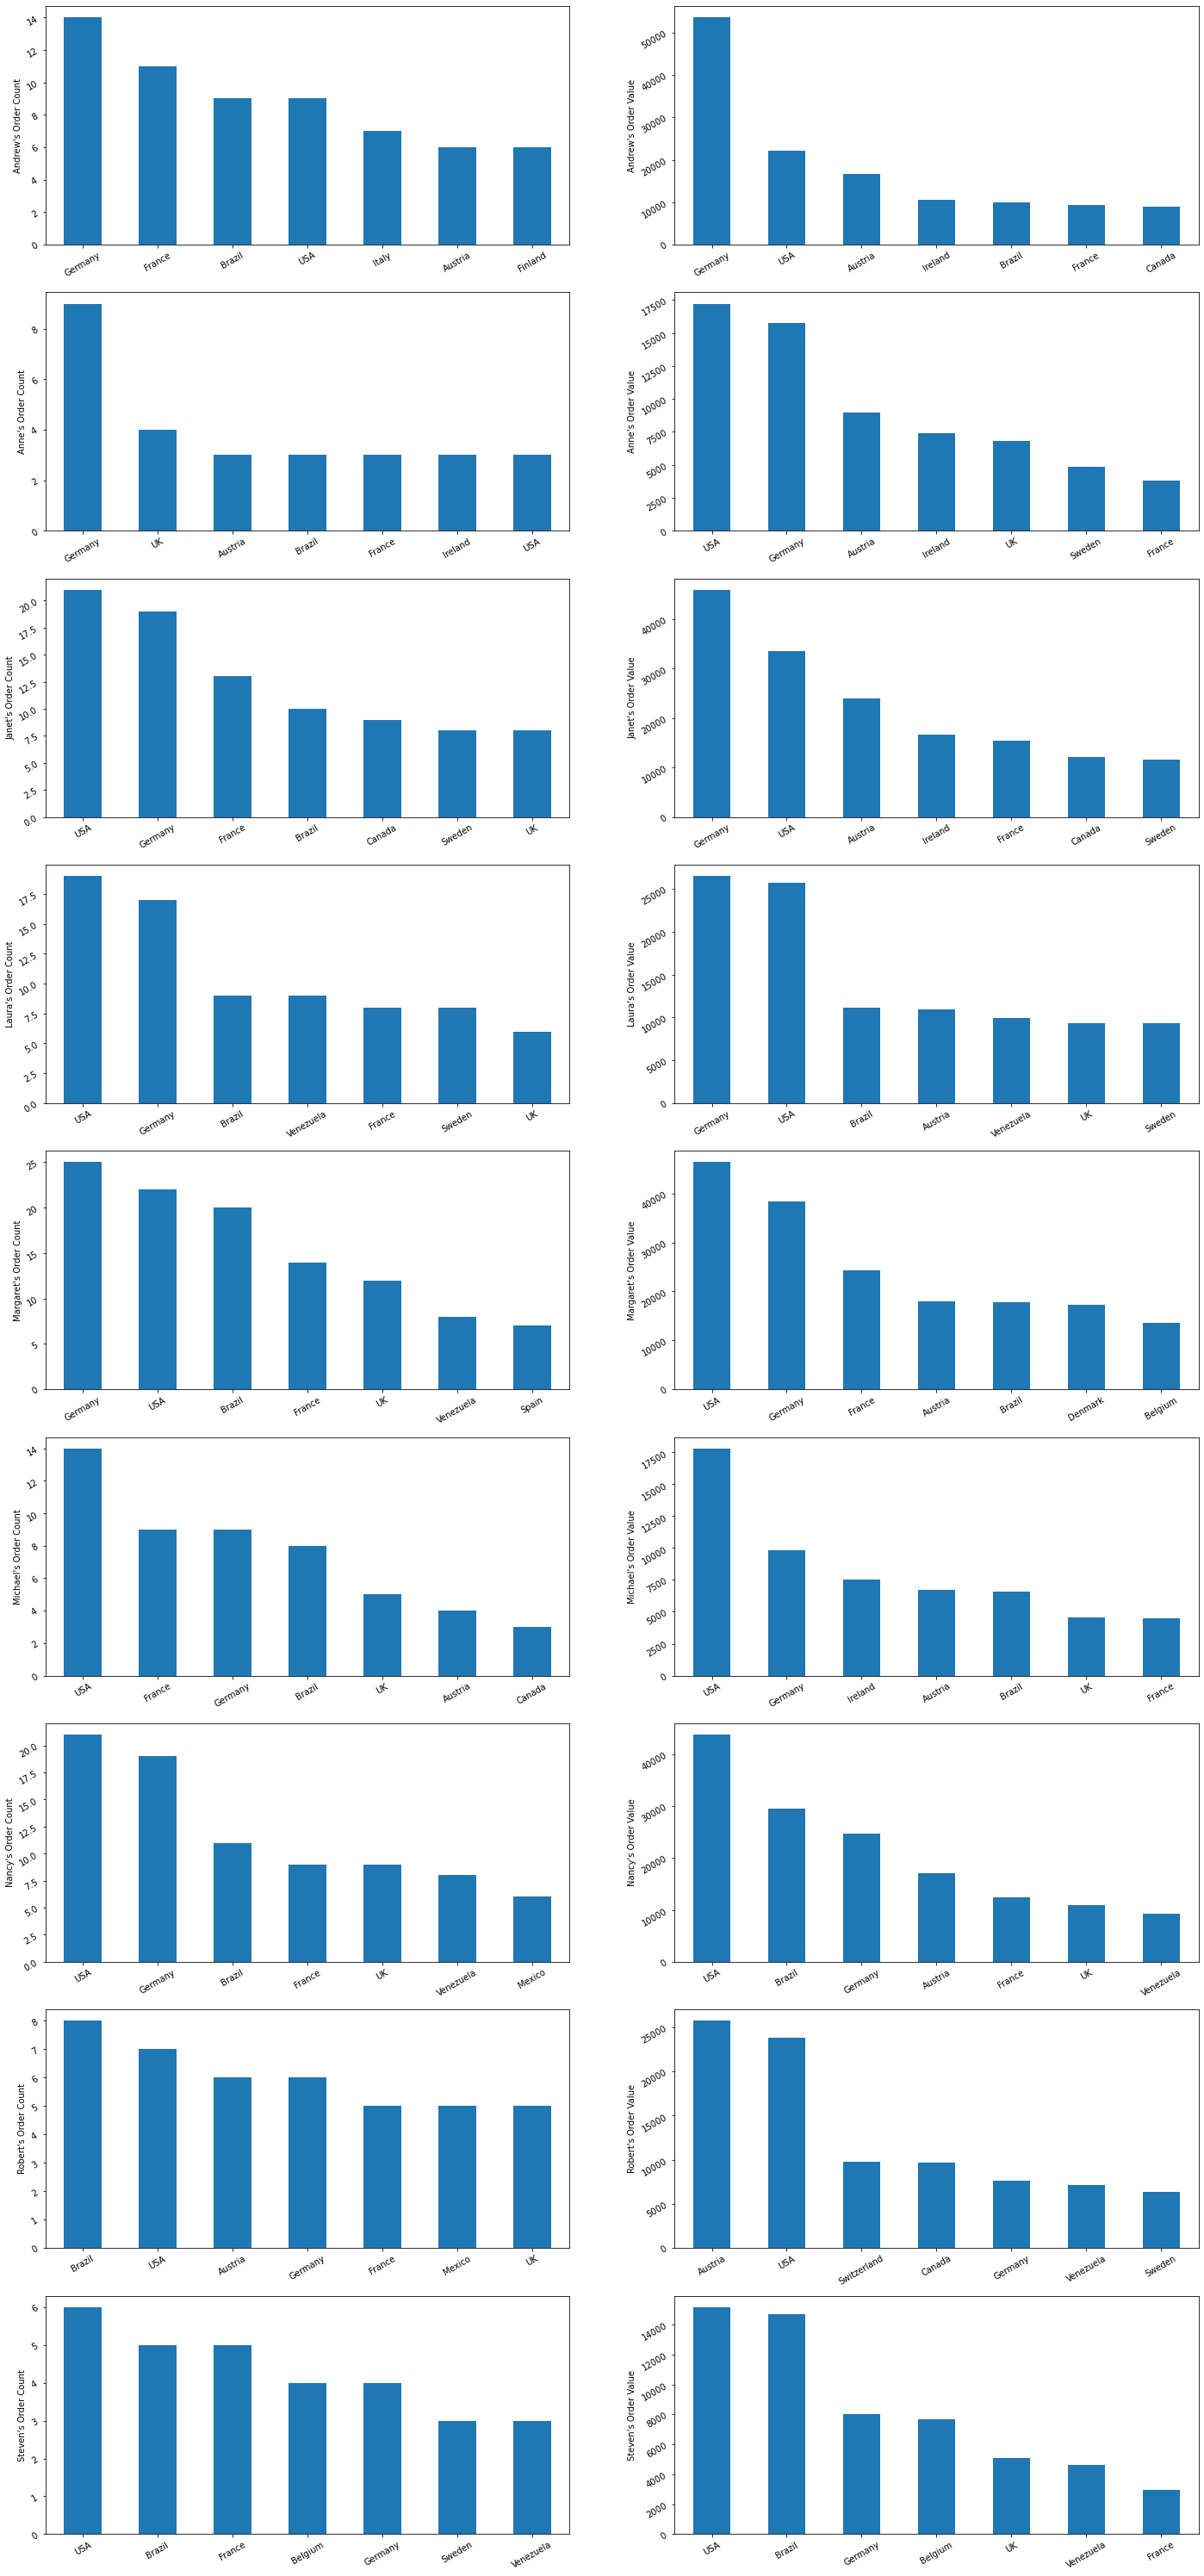

In [29]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(24, 54))
n_large = 7
for i in range(employee_customer.shape[0]):
    name = employee_customer.loc[i, 'FirstName']
    order_count = employee_country_order_count.iloc[i, :]
    order_value = employee_country_order_value.iloc[i, :]
    order_count.nlargest(n_large).plot(kind="bar", ax=ax[i, 0])
    order_value.nlargest(n_large).plot(kind="bar", ax=ax[i, 1])
    # Add labels
    ax[i, 0].set_title("")
    ax[i, 1].set_title("")
    ax[i, 0].set_xlabel("")
    ax[i, 1].set_xlabel("")
    ax[i, 0].set_ylabel(f"{name}'s Order Count")
    ax[i, 1].set_ylabel(f"{name}'s Order Value")
    ax[i, 0].tick_params(labelrotation=30)
    ax[i, 1].tick_params(labelrotation=30)
plt.show()

In [30]:
employee_least_country_dict = {}
for name, row in employee_country_order_count.iterrows():
    name_country = row.nsmallest(n_large)
    employee_least_country_dict[name] = (
        name_country.index + ", " + name_country.values.astype(str)
    )
employee_least_country = pd.DataFrame(employee_least_country_dict)
employee_least_country

,Andrew,Anne,Janet,Laura,Margaret,Michael,Nancy,Robert,Steven
0,"Poland, 0","Denmark, 0","Poland, 0","Belgium, 0","Norway, 0","Mexico, 0","Argentina, 1","Poland, 0","Argentina, 0"
1,"Portugal, 0","Mexico, 0","Argentina, 1","Norway, 0","Ireland, 1","Norway, 0","Belgium, 1","Finland, 1","Austria, 0"
2,"Switzerland, 0","Norway, 0","Belgium, 1","Ireland, 1","Poland, 2","Portugal, 0","Ireland, 1","Portugal, 1","Canada, 0"
3,"Argentina, 1","Poland, 0","Denmark, 1","Poland, 1","Canada, 3","Spain, 0","Finland, 2","Belgium, 2","Denmark, 0"
4,"Norway, 1","Canada, 1","Italy, 1","Switzerland, 1","Denmark, 3","Argentina, 1","Norway, 2","Canada, 2","Ireland, 0"
5,"Belgium, 2","Finland, 1","Norway, 1","Canada, 2","Finland, 3","Belgium, 1","Poland, 2","Ireland, 2","Norway, 0"
6,"Spain, 2","Portugal, 1","Finland, 2","Denmark, 2","Portugal, 3","Denmark, 1","Portugal, 2","Italy, 2","Italy, 1"


### Employees & Shipping

In [31]:
employee_ship = pd.read_sql_query(
    """
    SELECT e.EmployeeID, e.FirstName, e.LastName,
    o.OrderID, s.CompanyName AS Shipper, o.ShipCountry
    FROM Employees e 
    INNER JOIN Orders o
    ON e.EmployeeID = o.EmployeeID
    INNER JOIN Shippers s
    ON o.ShipVia = s.ShipperID
    """,
    con,
)
employee_ship = pd.merge(
    employee_ship, employee_order_value, on=["FirstName", "OrderID"]
)
employee_ship.head()

,EmployeeID,FirstName,LastName,OrderID,Shipper,ShipCountry,Value
0,5,Steven,Buchanan,10248,Federal Shipping,France,440.00
1,6,Michael,Suyama,10249,Speedy Express,Germany,1863.40
2,4,Margaret,Peacock,10250,United Package,Brazil,1552.60
3,3,Janet,Leverling,10251,Speedy Express,France,654.06
4,4,Margaret,Peacock,10252,United Package,Belgium,3597.90


In [32]:
employee_shipper_count_pivot = pd.pivot_table(
    employee_ship, index="FirstName", columns="Shipper", values="Value", aggfunc="count"
)
employee_shipper_count_pivot.head()

Shipper,Federal Shipping,Speedy Express,United Package
FirstName,,,
Andrew,25,35,36
Anne,14,10,19
Janet,46,36,45
Laura,29,27,48
Margaret,40,46,70


In [33]:
employee_shipper_value_pivot = pd.pivot_table(
    employee_ship, index="FirstName", columns="Shipper", values="Value", aggfunc=sum
)
employee_shipper_value_pivot.head()

Shipper,Federal Shipping,Speedy Express,United Package
FirstName,,,
Andrew,41277.9900,63299.8650,61959.9000
Anne,22718.2000,17694.5575,36895.3090
Janet,64357.3290,50455.8690,87999.6450
Laura,35529.2175,33962.9950,57370.0650
Margaret,67736.4250,58511.8885,106642.5325


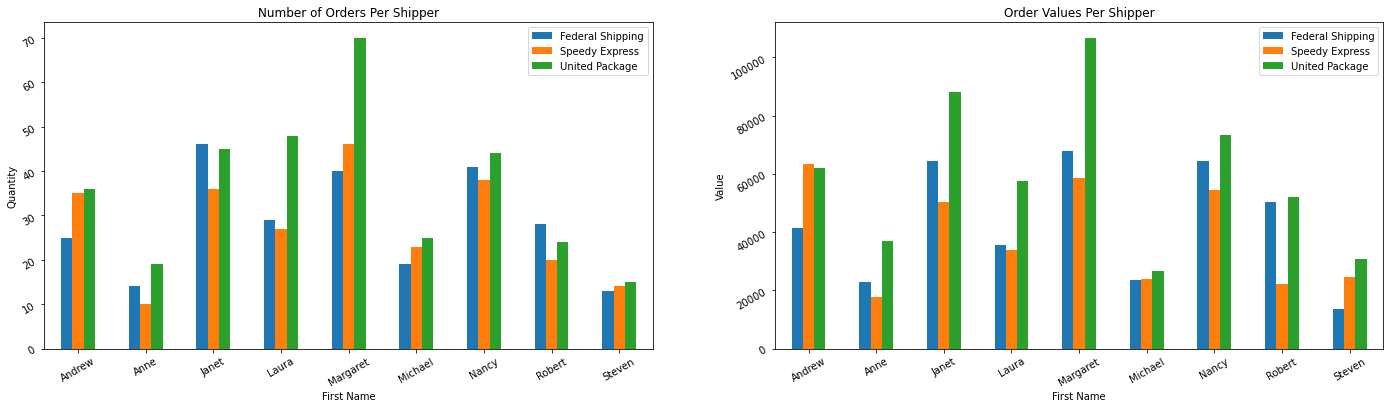

In [34]:
# Plotting
# Create the canvas
fig, ax = plt.subplots(ncols=2, figsize=(24, 6))
# Create barplots
employee_shipper_count_pivot.plot(kind="bar", ax=ax[0])
employee_shipper_value_pivot.plot(kind="bar", ax=ax[1])
# Add labels
ax[0].set_title("Number of Orders Per Shipper")
ax[0].set_xlabel("First Name")
ax[0].set_ylabel("Quantity")
ax[0].tick_params(labelrotation=30)
ax[0].get_legend().set_title("")
ax[1].set_title("Order Values Per Shipper")
ax[1].set_xlabel("First Name")
ax[1].set_ylabel("Value")
ax[1].tick_params(labelrotation=30)
ax[1].get_legend().set_title("")
# Show the image
plt.show()

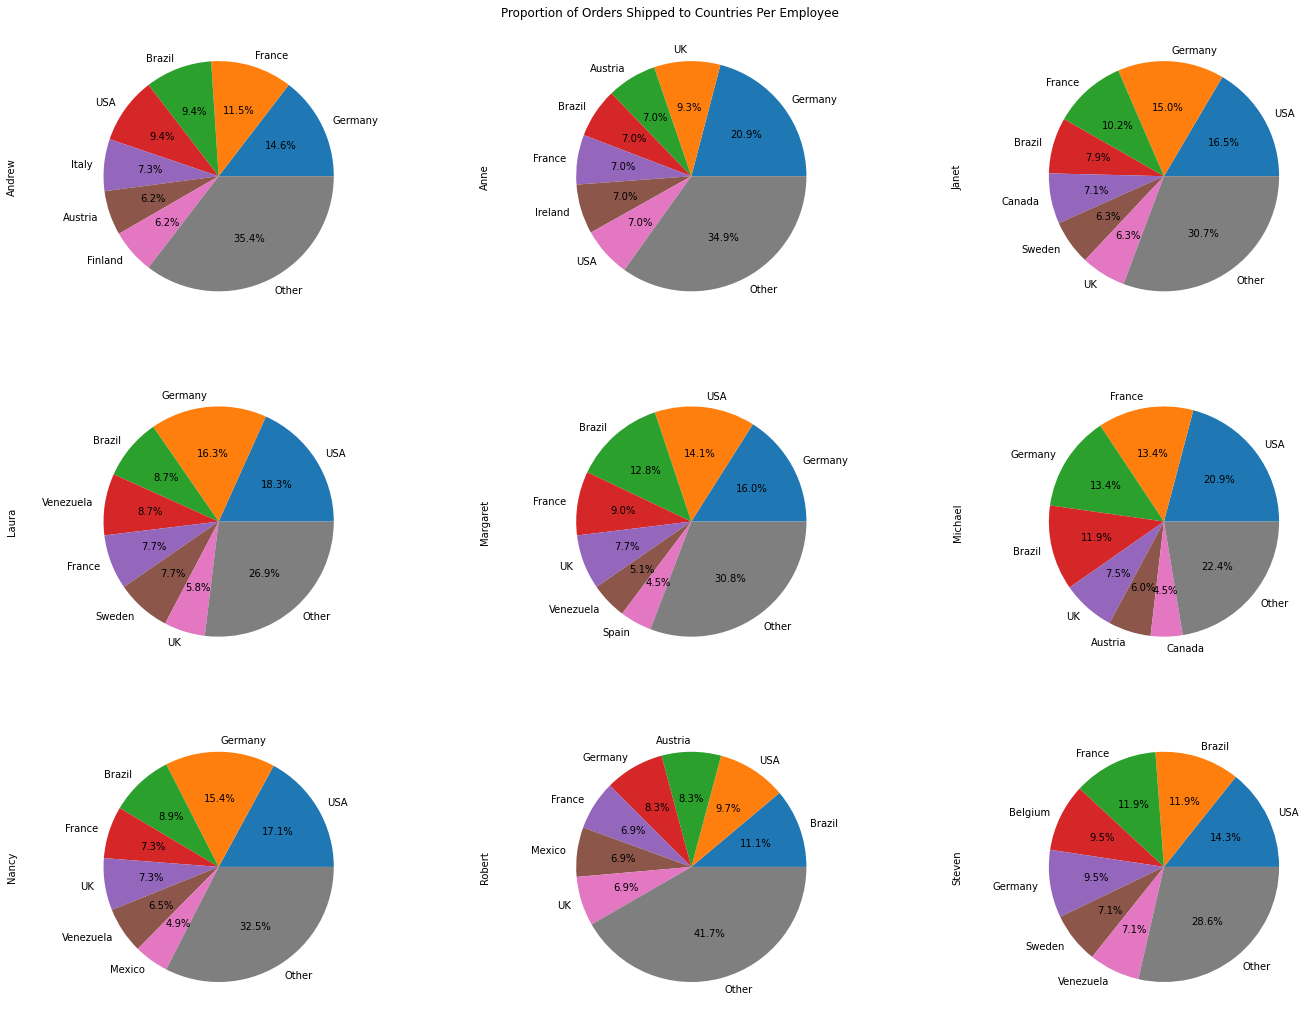

In [35]:
employee_shipcountry = pd.crosstab(
    employee_ship["FirstName"], employee_ship["ShipCountry"]
)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))
i = j = 0
for name, row in employee_shipcountry.iterrows():
    name_country = row.nlargest(n_large)
    name_country.loc['Other'] = row.drop(name_country.index).sum()
    name_country.plot(kind='pie', ax=ax[i, j], autopct='%1.1f%%')
    ax[i, j].yaxis.set_label_coords(-0.2, 0.5)
    j += 1
    if j == 3:
        i += 1
        j = 0
plt.suptitle('Proportion of Orders Shipped to Countries Per Employee', y=0.9)
plt.show()

## Summary